In [1]:
#Here we import the libraries that we need
import pyshtools as pysh
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import pygmt
from palettable import scientific as scm
import numpy as np
import h5py
import matplotlib.gridspec as gridspec

C:\Users\Annze\anaconda3\envs\spyder\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [66]:
#Import the dataset that was created by Tsunakawa et al. 2015 - Spherical harmonic expansion of the global magnetic field
pysh.utils.figstyle(rel_width=0.75) 
clm = pysh.datasets.Moon.T2015_449()
clm.info() 
#creation of the grid and initialization of parameters
grid = clm.expand() #creating the grid
Nlat = grid.nlat #latitude
Nlon = grid.nlon #longitude
#initialization of the magnetic field
Nz=100
Bx=np.zeros((Nlat,Nlon,Nz))
By=np.zeros((Nlat,Nlon,Nz))
Bz=np.zeros((Nlat,Nlon,Nz))
height=np.zeros(Nz)


kind = 'real'
normalization = 'schmidt'
csphase = 1
lmax = 449
r0 (m) = 1737400.0
error_kind = None
header = ['1737.4e3', '449']
header2 = None
name = 'T2015_449'
units = 'nT'
year = None


In [67]:
r= clm.r0 #mean radius of the Moon
for iz in range(0,Nz):
    height[iz]=r+iz*1e5 #here we can consider a smaller step for the altitude but due to the high point at which the pressures
    #become equal, we need a large step for the representation
    grid = clm.expand(a=height[iz])
    xgrid=grid.to_xarray()
    #We create the vactors for the magnetic components
    Bz[:,:,iz] = xgrid.radial.values
    By[:,:,iz] = xgrid.theta.values 
    Bx[:,:,iz] = xgrid.phi.values

In [68]:
#Computation of the total magnetic field and its regional analysis
B = np.sqrt(Bx**2+By**2+Bz**2) #global total magnetic intensity
#Regional analysis of the total magnetic field
#The regions were selected by studying the global map of the total magnetic field that was created by the previous script
B_Crisium = B[500:700,600:900,:] #Region 1
B_Orientale = B[500:700,900:1100,:] #Region 2
B_Imbrium = B[500:600,1100:1250,:] #Region 3
B_Serenitatis = B[300:450,300:550,:] #Region 4
B_Isolated = B[450:550,0:150,:] #Region 5

In [69]:
#Calculation of the magnetic pressure
B_tesla = B_Crisium*1e-09 #we first convert to Tesla
#m0 = 1.2566*10*1e-6 vacuum permeability
pm = (B_tesla**2)/0.00000251327 # Computation of the magnetic pressure Β^2/2μ0
#we now denote the x and y that we will plot
x = list(range(0,50))
y = pm[1,1,:]

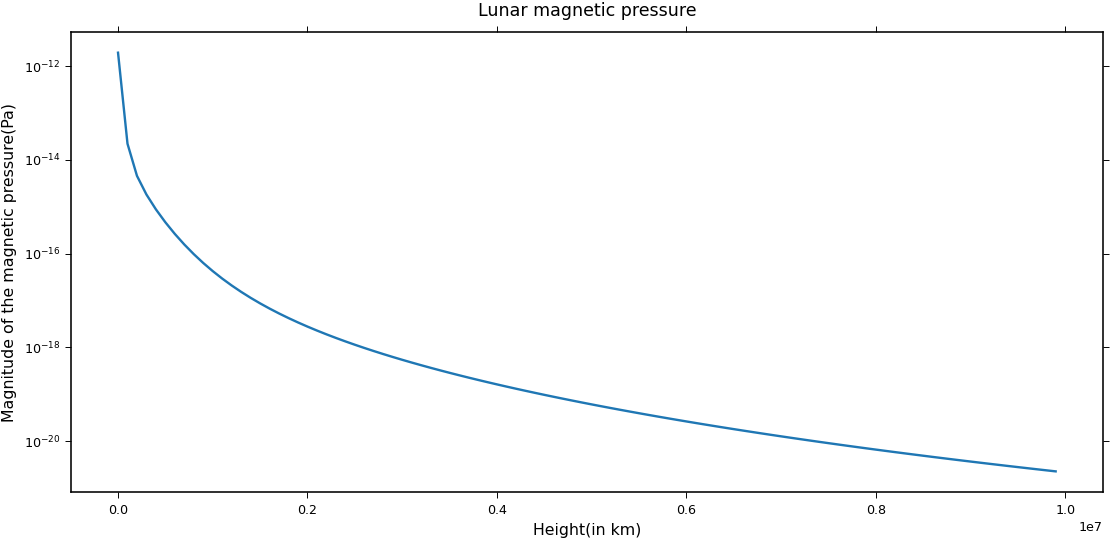

In [70]:
#Plot of the magnitude of the mangetic pressure to the height
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True
plt.plot(height-clm.r0,y)
plt.title('Lunar magnetic pressure')
plt.xlabel('Height(in km)')
plt.ylabel('Magnitude of the magnetic pressure(Pa)') #nPa^2 when B is in nT
plt.yscale('log')
#plt.xlim(20,30) In case that you need to focus on an interesting point
#plt.ylim(1,10)
#plt.show()

In [71]:
#Load data for New Moon of 21/03/2023
NewMoon_data= np.loadtxt('New Moon data 20_03_23 2.csv', delimiter=',') #data collected from SWPC data from DISCVR
NewMoon_B=NewMoon_data[:,1] #here I choose the columns that contain the values of the params I need
NewMoon_density=NewMoon_data[:,19]
NewMoon_velocity=NewMoon_data[:,22]
NewMoon_Temp=NewMoon_data[:,26]
NewMoon_B=NewMoon_B*1e-09 #to translate in Tesla 

In [72]:
def square(list):
    return [i ** 2 for i in list]

In [73]:
#Load data for Full Moon 07/03/2023
FullMoon_B = np.loadtxt('FullMoon_B', delimiter=',') #Themis data collected from OMNIWEB
FullMoon_density=np.loadtxt('FullMoon_density', delimiter=',')
FullMoon_velocity = np.loadtxt('FullMoon_velocity', delimiter=',')
FullMoon_thermalspeed = np.loadtxt('FullMoon_thermalspeed', delimiter=',')

In [74]:
FullMoon_B=np.array(FullMoon_B)
FullMoon_density = np.array(FullMoon_density)
FullMoon_thermalspped = np.array(FullMoon_thermalspeed)
#nanoTesla to Tesla
FullMoon_B = FullMoon_B*1e-09

In [75]:
#Calculation of the three pressures of the solar wind during the New Moon
pres_magn_new=(NewMoon_B**2)/(8*np.pi)
pres_ram_new = (NewMoon_velocity**2)*NewMoon_density*1.6726*1e-27
pres_us_new=NewMoon_density*1.380649*1e-23*NewMoon_Temp
#
#Elimination of errors, I replace some extreme values that are obviously errors of the machine
pres_magn_new[215]=1.91085006e-18
pres_magn_new[265]=2.14948698e-18
pres_magn_new[367]=2.58481952e-18
pres_us_new[215]=8.25085006e-18
pres_us_new[265]=7.41948698e-18
pres_us_new[367]=6.61481952e-18
pres_us_new[317]=8.25085006e-18
pres_ram_new[215]=1.45577994e-21
pres_ram_new[265]=1.92355904e-21
pres_ram_new[367]=1.29842056e-21
pres_ram_new[317]=1.48775076e-21
#Calculation of total and average pressures
NewMoon_averPres = (pres_magn_new+pres_ram_new+pres_us_new)/3
NewMoon_total = pres_magn_new+pres_ram_new+pres_us_new
#Now we eliminate some leftover errors
NewMoon_averPres[215]=6.36950019e-18 #to limit the influence of errors, I replace some extreme values that are obviously errors of the machine
NewMoon_averPres[265]=6.36950019e-18
NewMoon_averPres[367]=8.61606505e-18
NewMoon_averPres[317]=6.36950019e-18
NewMoon_total[215]=8.25085006e-18
NewMoon_total[265]=3.97948698e-18
NewMoon_total[367]=3.97481952e-18
NewMoon_total[317]=8.25085006e-18

In [76]:
#Calculation of the three pressures of the solar wind during the Full Moon (for the lobes)
pres_magn_full=(FullMoon_B**2)/(8*np.pi)
pres_ram_full = (FullMoon_velocity**2)*FullMoon_density*1.6726*1e-27 #this is in Pascal
#we want to switch to nPa^2 to be the same units with the others
#Here I use the thermal speed to calculate the usual pressure
vthsquare= square(FullMoon_thermalspeed)
pres_us_full=FullMoon_density*1.380649*1e-23*vthsquare
FullMoon_averPres = (pres_magn_full+pres_ram_full+pres_us_full)/3
FullMoon_total = pres_magn_full+pres_ram_full+pres_us_full

Text(0.5, 0, 'Height(in 100km)')

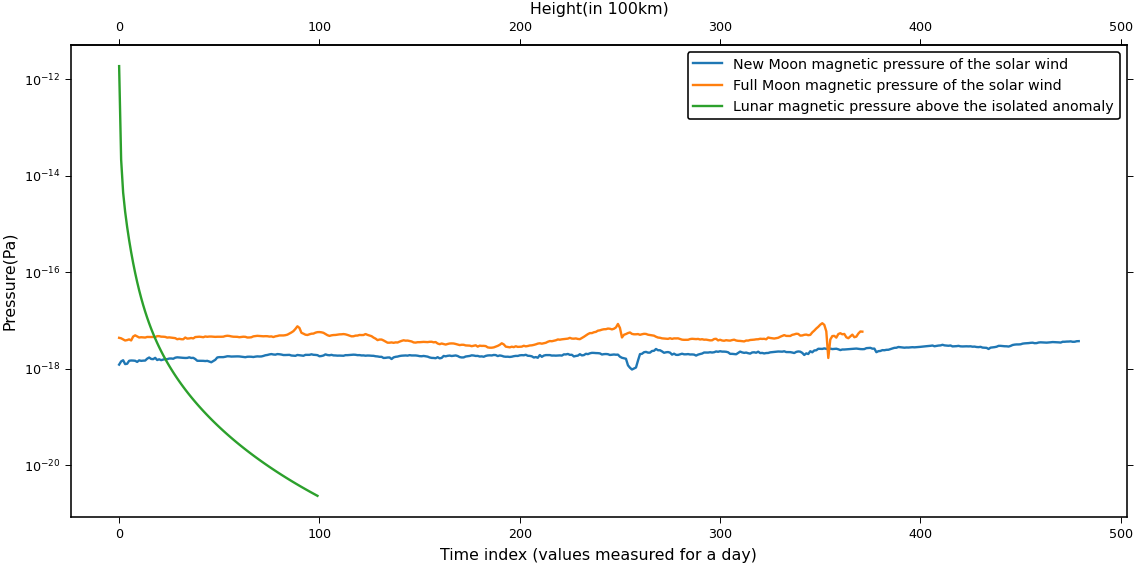

In [78]:
#Plot of the magnetic pressures
fig, ax = plt.subplots(layout='constrained')
ax.plot(pres_magn_new, label='New Moon magnetic pressure of the solar wind')
ax.plot(pres_magn_full, label='Full Moon magnetic pressure of the solar wind')
ax.plot(pm[1,1,:], label='Lunar magnetic pressure above the isolated anomaly')
ax.set_xlabel("Time index (values measured for a day)")
ax.set_ylabel("Pressure(Pa)")
ax.set_yscale('log')
plt.legend()
secax = ax.secondary_xaxis('top')
secax.set_xlabel('Height(in 100km)')

Text(0.5, 0, 'Height(in 100km)')

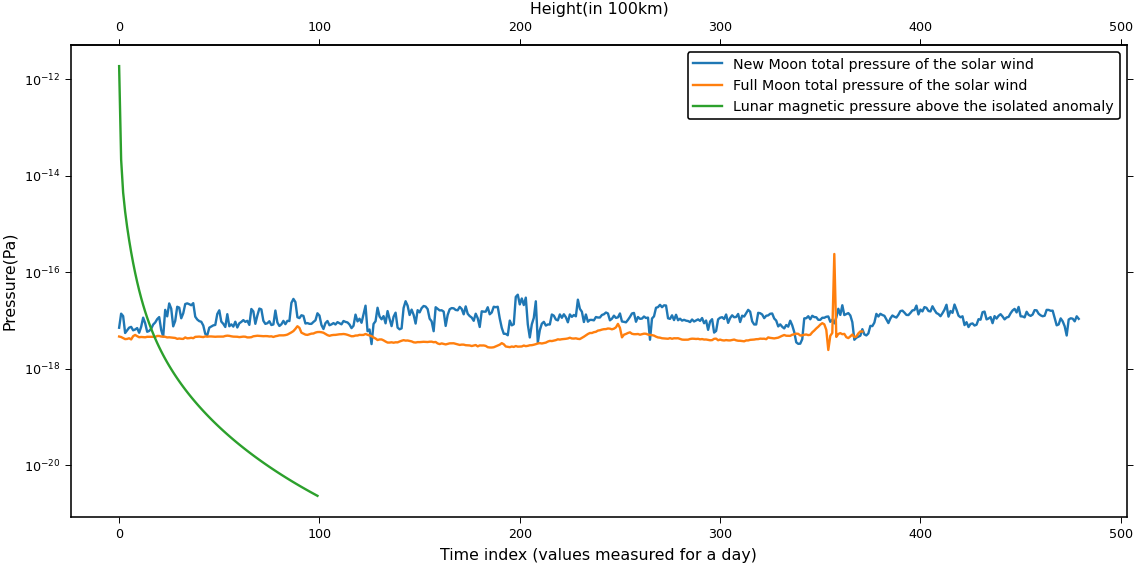

In [79]:
#Plot of the total pressures with the magnetic pressure of the Moon
fig, ax = plt.subplots(layout='constrained')
ax.plot(NewMoon_total, label='New Moon total pressure of the solar wind')
ax.plot(FullMoon_total, label='Full Moon total pressure of the solar wind')
ax.plot(pm[1,1,:], label='Lunar magnetic pressure above the isolated anomaly')
ax.set_xlabel("Time index (values measured for a day)")
ax.set_ylabel("Pressure(Pa)")
ax.set_yscale('log')
plt.legend()
secax = ax.secondary_xaxis('top')
secax.set_xlabel('Height(in 100km)')

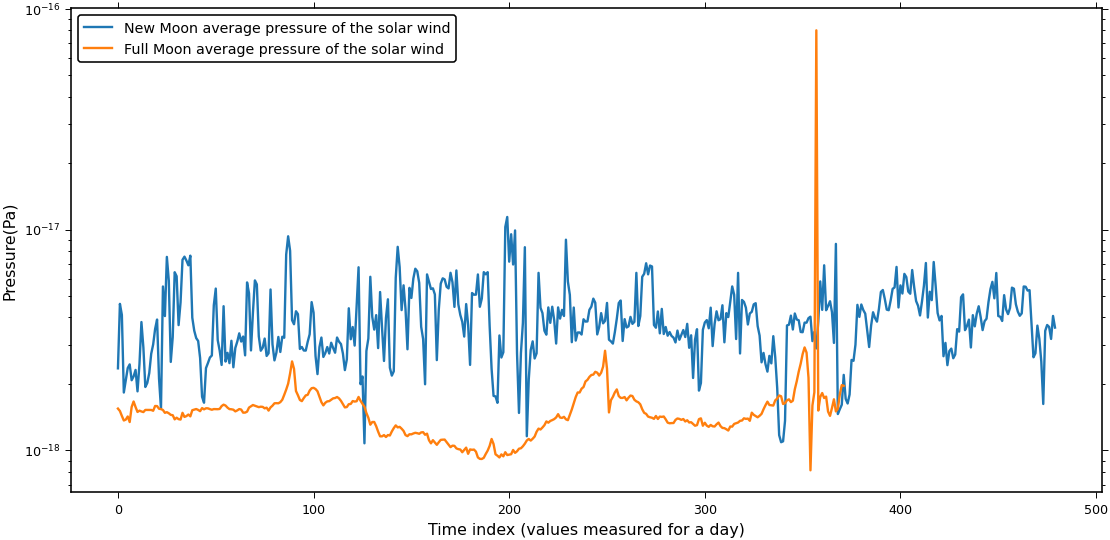

In [80]:
#Plot of the average pressures and the magnetic pressure
plt.plot(NewMoon_averPres, label='New Moon average pressure of the solar wind')
plt.plot(FullMoon_averPres, label='Full Moon average pressure of the solar wind')
plt.legend()
plt.xlabel("Time index (values measured for a day)")
plt.ylabel("Pressure(Pa)")
plt.yscale('log')

Text(0.5, 0, 'Height(in 100km)')

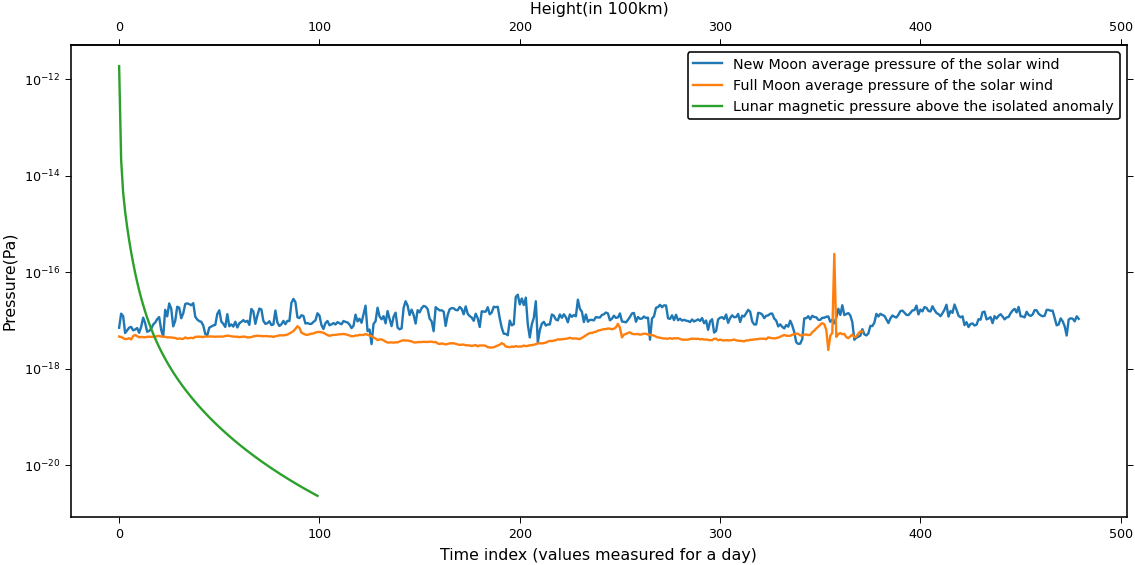

In [81]:
#Plot of the total pressures and the magnetic pressure
fig, ax = plt.subplots(layout='constrained')
ax.plot(NewMoon_total, label='New Moon average pressure of the solar wind')
ax.plot(FullMoon_total, label='Full Moon average pressure of the solar wind')
ax.plot(pm[1,1,:], label='Lunar magnetic pressure above the isolated anomaly')
ax.set_xlabel("Time index (values measured for a day)")
ax.set_ylabel("Pressure(Pa)")
ax.set_yscale('log')
plt.legend()
secax = ax.secondary_xaxis('top')
secax.set_xlabel('Height(in 100km)')

In [82]:
#Here we calculate the typical - mean value of the Full Moon pressures
full_mean = np.mean(FullMoon_total)
full_mean = full_mean*np.ones(500)
full_magn = np.mean(pres_magn_full)
full_magn = full_magn*np.ones(500)
full_ram = np.mean(pres_ram_full)
full_ram = full_ram*np.ones(500)
full_us = np.mean(pres_us_full)
full_us = full_us*np.ones(500)

In [83]:
#Here we calculate the typical - mean value of the New Moon pressures
new_mean = np.mean(NewMoon_total)
new_mean = new_mean*np.ones(500)
new_magn = pres_magn_new[90]
new_magn = new_magn*np.ones(500)
new_ram = np.mean(pres_ram_new)
new_ram = new_ram*np.ones(500)
new_us = np.mean(pres_us_new)
new_us = new_us*np.ones(500)

Text(0.5, 0, 'Height(in km)')

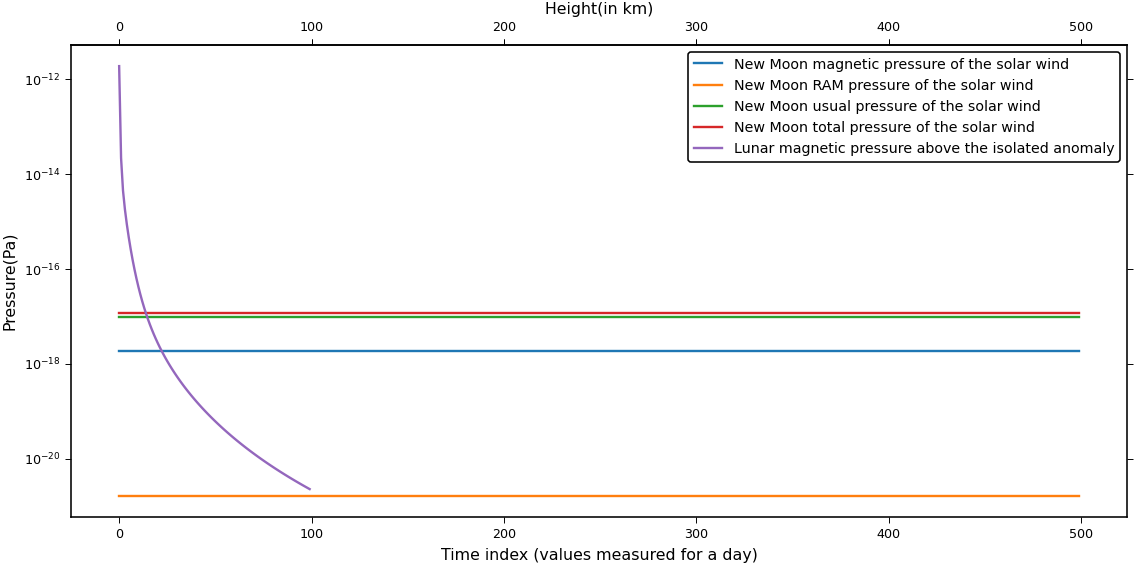

In [84]:
#Plot of typical values of New Moon pressures and the magnetic pressure
fig, ax = plt.subplots(layout='constrained')
ax.plot(new_magn, label='New Moon magnetic pressure of the solar wind')
ax.plot(new_ram, label='New Moon RAM pressure of the solar wind')
ax.plot(new_us, label='New Moon usual pressure of the solar wind')
ax.plot(new_mean, label='New Moon total pressure of the solar wind')
ax.plot(pm[1,1,:], label='Lunar magnetic pressure above the isolated anomaly')
ax.set_xlabel("Time index (values measured for a day)")
ax.set_ylabel("Pressure(Pa)")
ax.set_yscale('log')
#ax.set_xlim(0,100)
plt.legend()
secax = ax.secondary_xaxis('top')
secax.set_xlabel('Height(in km)')


Text(0.5, 0, 'Height(in km)')

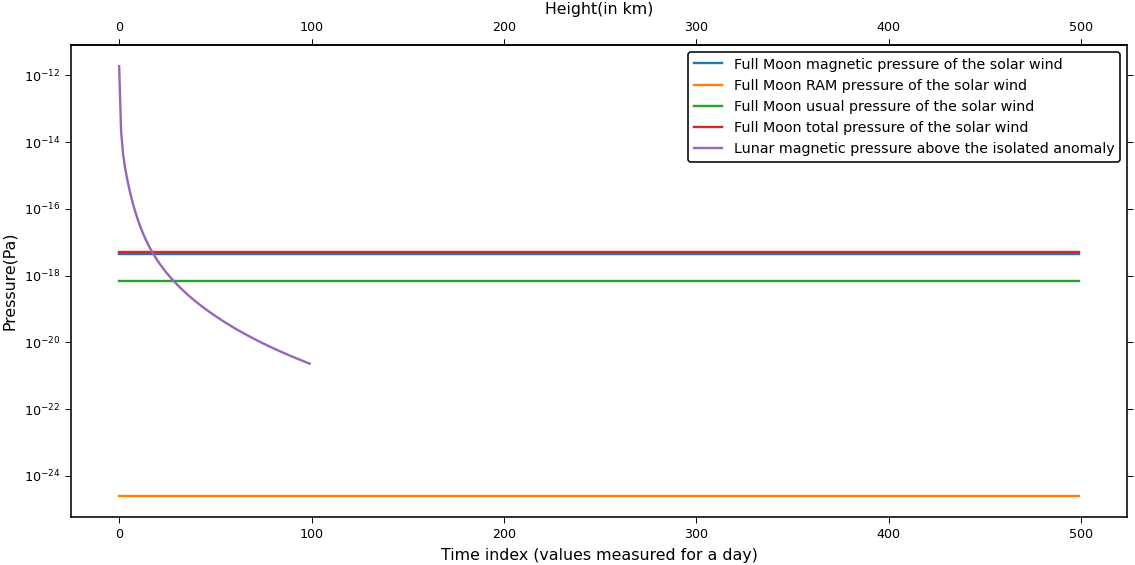

In [85]:
#Plot of typical values of Full Moon pressures and the magnetic pressure
fig, ax = plt.subplots(layout='constrained')
ax.plot(full_magn, label='Full Moon magnetic pressure of the solar wind')
ax.plot(full_ram, label='Full Moon RAM pressure of the solar wind')
ax.plot(full_us, label='Full Moon usual pressure of the solar wind')
ax.plot(full_mean, label='Full Moon total pressure of the solar wind')
ax.plot(pm[1,1,:], label='Lunar magnetic pressure above the isolated anomaly')
ax.set_xlabel("Time index (values measured for a day)")
ax.set_ylabel("Pressure(Pa)")
ax.set_yscale('log')
#ax.set_xlim(0,100)
plt.legend()
secax = ax.secondary_xaxis('top')
secax.set_xlabel('Height(in km)')

Text(0.5, 0, 'Height(in 100km)')

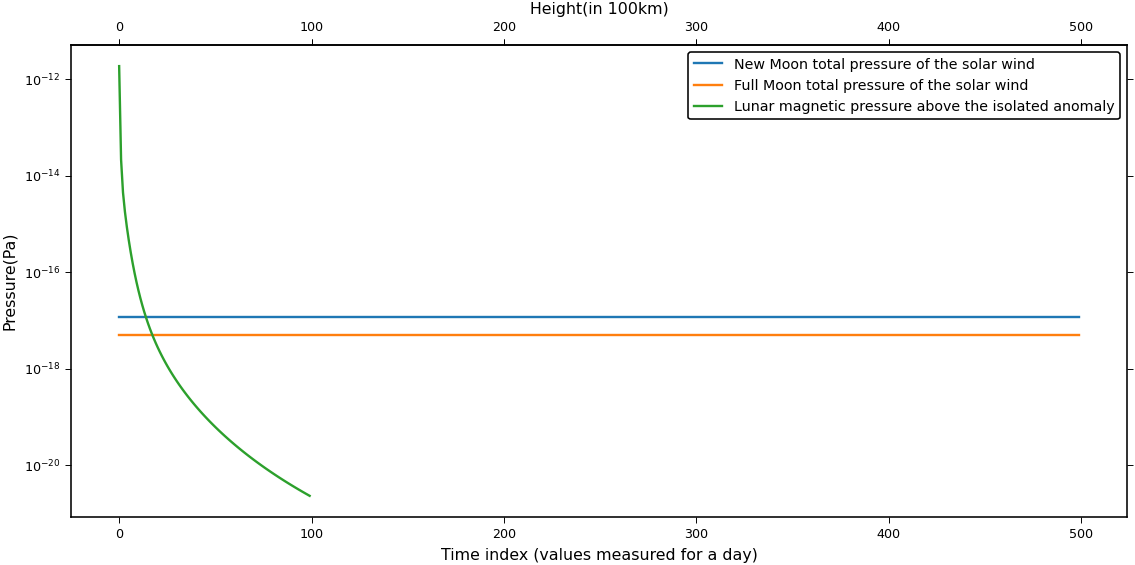

In [88]:
#Plot of typical values of the total pressures and the magnetic pressure
fig, ax = plt.subplots(layout='constrained')
ax.plot(new_mean, label='New Moon total pressure of the solar wind')
ax.plot(full_mean, label='Full Moon total pressure of the solar wind')
ax.plot(pm[1,1,:], label='Lunar magnetic pressure above the isolated anomaly')
ax.set_xlabel("Time index (values measured for a day)")
ax.set_ylabel("Pressure(Pa)")
ax.set_yscale('log')
#ax.set_xlim(0,20)
plt.legend()
secax = ax.secondary_xaxis('top')
secax.set_xlabel('Height(in 100km)')

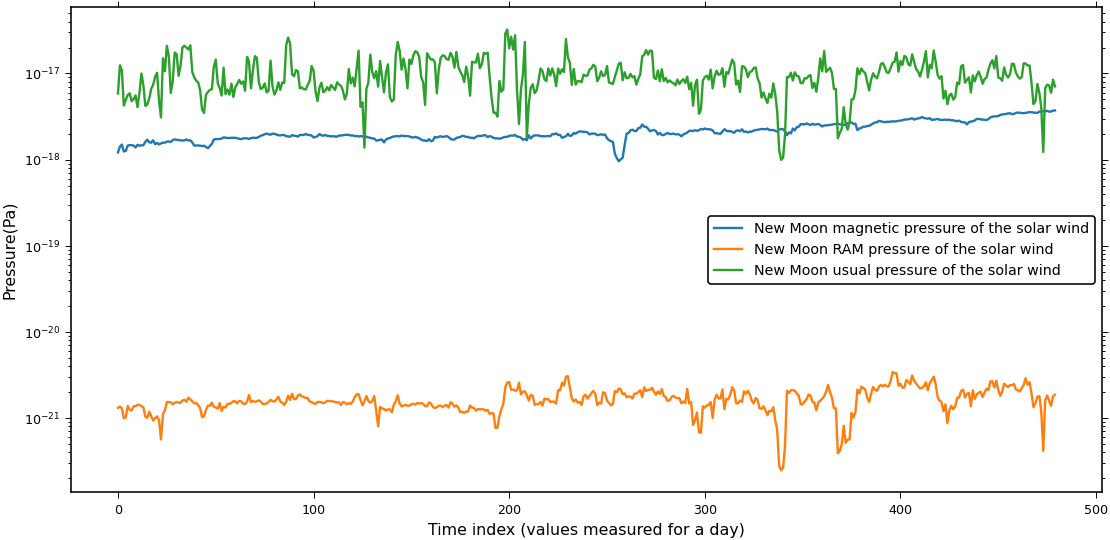

In [89]:
#Plot of the three New Moon pressures
plt.plot(pres_magn_new, label='New Moon magnetic pressure of the solar wind')
plt.plot(pres_ram_new, label='New Moon RAM pressure of the solar wind')
plt.plot(pres_us_new, label='New Moon usual pressure of the solar wind') 
plt.legend()
plt.xlabel("Time index (values measured for a day)")
plt.ylabel("Pressure(Pa)")
plt.yscale('log')

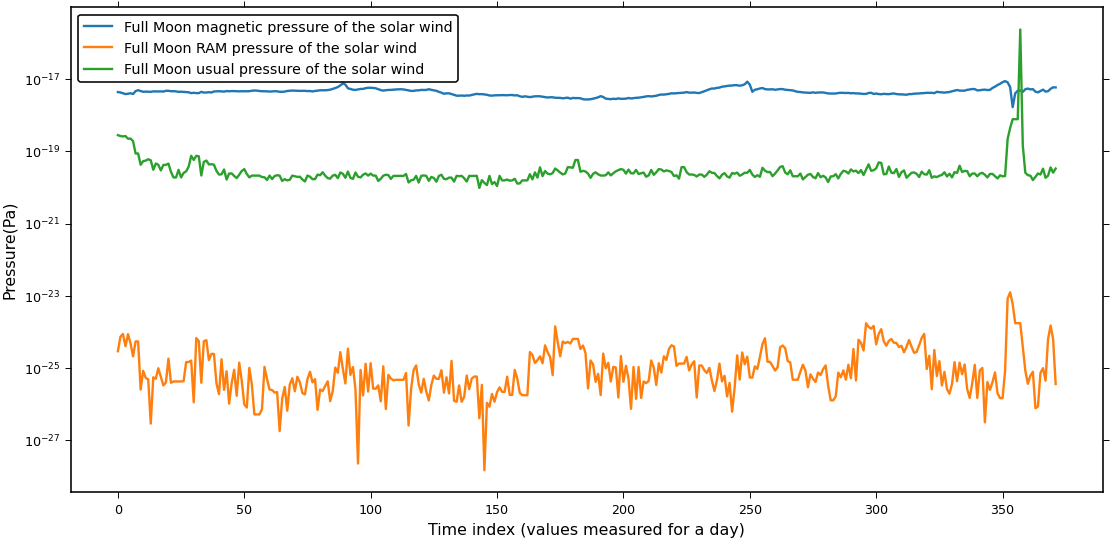

In [90]:
#Plot of the three Full Moon pressures
plt.plot(pres_magn_full, label='Full Moon magnetic pressure of the solar wind')
plt.plot(pres_ram_full, label='Full Moon RAM pressure of the solar wind')
plt.plot(pres_us_full, label='Full Moon usual pressure of the solar wind') 
plt.legend()
plt.xlabel("Time index (values measured for a day)")
plt.ylabel("Pressure(Pa)")
plt.yscale('log')

Text(0.5, 0, 'Height(in km)')

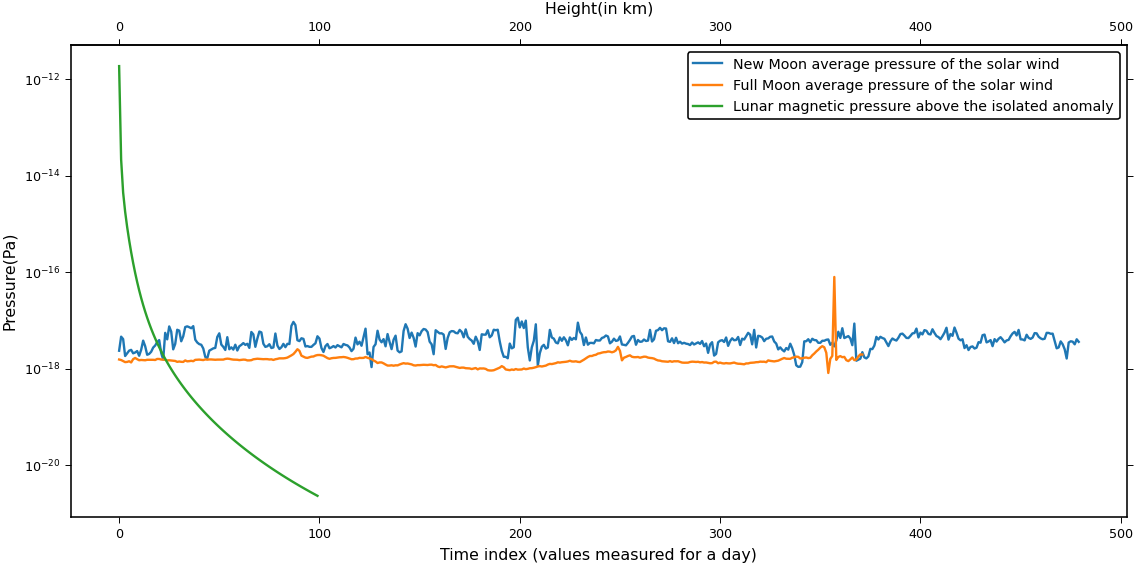

In [91]:
#Plot of the average pressures and the magnetic pressure
fig, ax = plt.subplots(layout='constrained')
ax.plot(NewMoon_averPres, label='New Moon average pressure of the solar wind')
ax.plot(FullMoon_averPres, label='Full Moon average pressure of the solar wind')
ax.plot(pm[1,1,:], label='Lunar magnetic pressure above the isolated anomaly')
ax.set_xlabel("Time index (values measured for a day)")
ax.set_ylabel("Pressure(Pa)")
ax.set_yscale('log')
#ax.set_xlim(0,100)
plt.legend()
secax = ax.secondary_xaxis('top')
secax.set_xlabel('Height(in km)')